In [1]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
from tensorflow import keras

Execute

```
git clone https://github.com/alexeygrigorev/clothing-dataset-small.git
```

to get the data

## Transfer learning

Instead of loading each image one-by-one, we can use a data generator. Keras will use it for loading the images and pre-processing them

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input

We'll use smaller images - it'll be faster

In [5]:
image_size = (150, 150)
batch_size = 32

Let's get train data:

In [6]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_gen.flow_from_directory(
    "C:/Users/Odiaka/My_Shit/workspace/chest_xray/train",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,class_mode='categorical'
)

Found 5216 images belonging to 2 classes.


In [7]:
train_ds.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

And validation:

In [8]:
validation_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = validation_gen.flow_from_directory(
    "C:/Users/Odiaka/My_Shit/workspace/chest_xray/val",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,class_mode='categorical'
)

Found 656 images belonging to 2 classes.


For fine-tuning, we'll use `Xception` with small images (150x150)

In [9]:
from tensorflow.keras.applications import Xception

In [10]:
base_model = Xception(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False #leave out dense layers
)

base_model.trainable = False

Let's add a small neural net on top of that: just one layer with 10 neurons (there are 10 classes we want to predict)

In [11]:
inputs = keras.Input(shape=(150, 150, 3))

base = base_model(inputs, training=False)
vectors = keras.layers.GlobalAveragePooling2D()(base)
outputs = keras.layers.Dense(2)(vectors)

model = keras.Model(inputs, outputs)

Now we specify the learning rate and compile the model. After that, it's ready for training

For optimizers, binary classification = binarycrossentropy, multi class = categorical crossentropy, regression=meansquared

If we dont assign activation in our optimizer, then from_logits is True. Otherwise, it is false.

In [12]:
def make_model(learning_rate):
    base_model = Xception(
        weights='imagenet',
        input_shape=(150, 150, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))
    
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)


    outputs = keras.layers.Dense(2)(vectors)

    model = keras.Model(inputs, outputs)
    

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    
    return model

In [13]:
model = make_model(learning_rate=0.01)


callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]


history = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=callbacks)

Epoch 1/10
163/163 [==============================] - 147s 885ms/step - loss: 0.3323 - accuracy: 0.9214 - val_loss: 0.1703 - val_accuracy: 0.9466
Epoch 2/10
163/163 [==============================] - 124s 759ms/step - loss: 0.1520 - accuracy: 0.9505 - val_loss: 0.1716 - val_accuracy: 0.9527
Epoch 3/10
163/163 [==============================] - 124s 760ms/step - loss: 0.1386 - accuracy: 0.9580 - val_loss: 0.1185 - val_accuracy: 0.9604
Epoch 4/10
163/163 [==============================] - 124s 758ms/step - loss: 0.1189 - accuracy: 0.9626 - val_loss: 0.1461 - val_accuracy: 0.9649
Epoch 5/10
163/163 [==============================] - 124s 762ms/step - loss: 0.0950 - accuracy: 0.9684 - val_loss: 0.1043 - val_accuracy: 0.9695
Epoch 6/10
163/163 [==============================] - 123s 757ms/step - loss: 0.1057 - accuracy: 0.9691 - val_loss: 0.1588 - val_accuracy: 0.9604
Epoch 7/10
163/163 [==============================] - 123s 757ms/step - loss: 0.0719 - accuracy: 0.9764 - val_loss: 0.2869 -

## Tuning the Performance of the model

### Adjusting the learning rate

In [14]:
def make_model(learning_rate):
    base_model = Xception(
        weights='imagenet',
        input_shape=(150, 150, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))
    
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)


    outputs = keras.layers.Dense(2)(vectors)

    model = keras.Model(inputs, outputs)
    

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    loss = keras.losses.BinaryCrossentropy(from_logits=True)

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    
    return model

In [15]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    model = make_model(learning_rate=lr)

    callbacks = [
    keras.callbacks.ModelCheckpoint(
        "xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
            )
              ]

    history = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=callbacks)
    scores[lr] = history.history

Epoch 1/10
163/163 [==============================] - 127s 763ms/step - loss: 0.4057 - accuracy: 0.8219 - val_loss: 0.3267 - val_accuracy: 0.8674
Epoch 2/10
163/163 [==============================] - 125s 765ms/step - loss: 0.2661 - accuracy: 0.9026 - val_loss: 0.2699 - val_accuracy: 0.8796
Epoch 3/10
163/163 [==============================] - 125s 765ms/step - loss: 0.2241 - accuracy: 0.9170 - val_loss: 0.2392 - val_accuracy: 0.8963
Epoch 4/10
163/163 [==============================] - 125s 768ms/step - loss: 0.2021 - accuracy: 0.9248 - val_loss: 0.2227 - val_accuracy: 0.9024
Epoch 5/10
163/163 [==============================] - 124s 762ms/step - loss: 0.1872 - accuracy: 0.9275 - val_loss: 0.2098 - val_accuracy: 0.9131
Epoch 6/10
163/163 [==============================] - 123s 757ms/step - loss: 0.1762 - accuracy: 0.9333 - val_loss: 0.1998 - val_accuracy: 0.9116
Epoch 7/10
163/163 [==============================] - 123s 756ms/step - loss: 0.1670 - accuracy: 0.9360 - val_loss: 0.1922 -

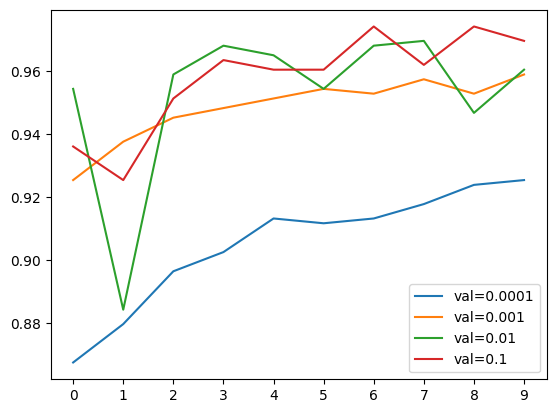

In [16]:
for lr, hist in scores.items():
    #plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

Check on 0.1 and 0.01 only

In [17]:
keys = [0.1,0.01]
scores_interest = {x:scores[x] for x in keys}

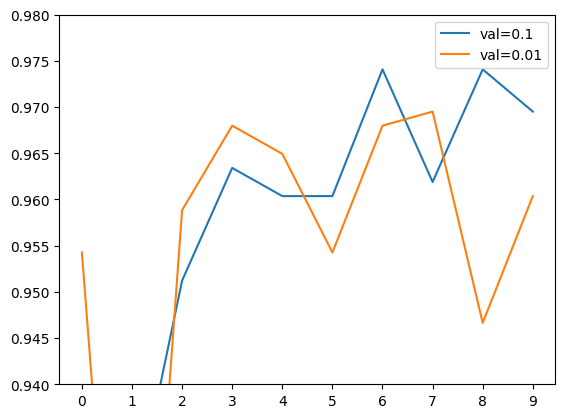

In [26]:
for lr, hist in scores_interest.items():
    #plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.ylim(0.94,0.98)
plt.xticks(np.arange(10))
plt.legend()

Based on the result, we will use 0.1 for the learning rate.

In [21]:
learning_rate = 0.1

## Adding additional layer

In [28]:
def make_model(learning_rate=0.1, size_inner=100):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    
    outputs = keras.layers.Dense(2)(inner)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [29]:
learning_rate = 0.1

scores = {}

for size in [10, 100, 1000]:
    print(size)

    model = make_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[size] = history.history

    print()
    print()

10
Epoch 1/10
163/163 [==============================] - 147s 885ms/step - loss: 1.3224 - accuracy: 0.8949 - val_loss: 0.3038 - val_accuracy: 0.8826
Epoch 2/10
163/163 [==============================] - 145s 891ms/step - loss: 0.1827 - accuracy: 0.9296 - val_loss: 0.1873 - val_accuracy: 0.9345
Epoch 3/10
163/163 [==============================] - 145s 887ms/step - loss: 0.1666 - accuracy: 0.9362 - val_loss: 0.1737 - val_accuracy: 0.9268
Epoch 4/10
163/163 [==============================] - 149s 913ms/step - loss: 0.1717 - accuracy: 0.9283 - val_loss: 0.4267 - val_accuracy: 0.6707
Epoch 5/10
163/163 [==============================] - 148s 905ms/step - loss: 0.1972 - accuracy: 0.9214 - val_loss: 0.2939 - val_accuracy: 0.8354
Epoch 6/10
163/163 [==============================] - 148s 906ms/step - loss: 0.1539 - accuracy: 0.9410 - val_loss: 0.2780 - val_accuracy: 0.9116
Epoch 7/10
163/163 [==============================] - 147s 901ms/step - loss: 0.1645 - accuracy: 0.9410 - val_loss: 0.201

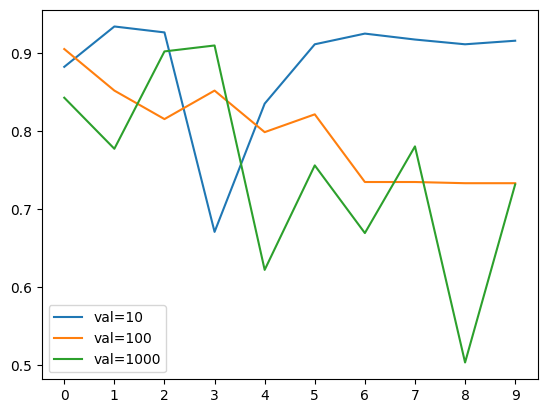

In [30]:
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))

plt.xticks(np.arange(10))
#plt.yticks([0.78, 0.80, 0.82, 0.825, 0.83])
plt.legend()

Choose 10 for the size

## Regularization and Dropout

Regularizing by freezing a part of the network
Adding dropout to our model
Experimenting with different values

In [35]:
def make_model(learning_rate=0.1, size_inner=10, droprate=0.5):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    
    outputs = keras.layers.Dense(2)(drop)
    
    model = keras.Model(inputs, outputs)
    
    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [36]:
learning_rate = 0.1
size = 10

scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)

    model = make_model(
        learning_rate=learning_rate,
        size_inner=size,
        droprate=droprate
    )

    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[droprate] = history.history

    print()
    print()

0.0
Epoch 1/10
163/163 [==============================] - 156s 944ms/step - loss: 0.5962 - accuracy: 0.7488 - val_loss: 0.5816 - val_accuracy: 0.7317
Epoch 2/10
163/163 [==============================] - 155s 950ms/step - loss: 0.5737 - accuracy: 0.7429 - val_loss: 0.5822 - val_accuracy: 0.7317
Epoch 3/10
163/163 [==============================] - 154s 944ms/step - loss: 0.5756 - accuracy: 0.7427 - val_loss: 0.5942 - val_accuracy: 0.7317
Epoch 4/10
163/163 [==============================] - 153s 936ms/step - loss: 0.5721 - accuracy: 0.7429 - val_loss: 0.5816 - val_accuracy: 0.7317
Epoch 5/10
163/163 [==============================] - 154s 941ms/step - loss: 0.5725 - accuracy: 0.7429 - val_loss: 0.5816 - val_accuracy: 0.7317
Epoch 6/10
163/163 [==============================] - 154s 946ms/step - loss: 0.5723 - accuracy: 0.7429 - val_loss: 0.5912 - val_accuracy: 0.7317
Epoch 7/10
163/163 [==============================] - 153s 935ms/step - loss: 0.5722 - accuracy: 0.7429 - val_loss: 0.58

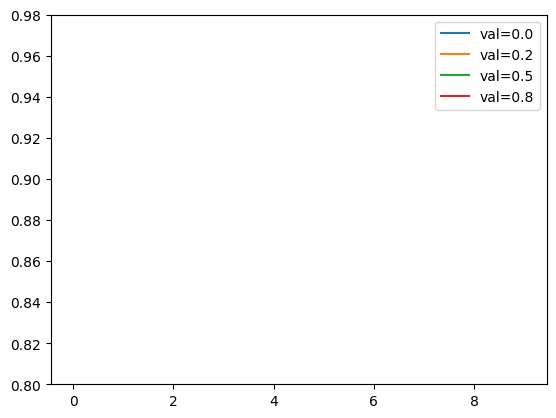

In [37]:
for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))

plt.ylim(0.8, 0.98)
plt.legend()

Choose droprate = 0.2

In [38]:
def make_model(learning_rate):
    base_model = Xception(
        weights='imagenet',
        input_shape=(150, 150, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))
    
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)


    outputs = keras.layers.Dense(2)(vectors)

    model = keras.Model(inputs, outputs)
    

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    loss = keras.losses.BinaryCrossentropy(from_logits=True)

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    
    return model

In [40]:
learning_rate = 0.1
#size = 10
#droprate = 0.2

model = make_model(
    learning_rate=learning_rate,
    #size_inner=size,
    #droprate=droprate
)

history = model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
163/163 [==============================] - 151s 911ms/step - loss: 1.5642 - accuracy: 0.9036 - val_loss: 1.3382 - val_accuracy: 0.9085
Epoch 2/20
163/163 [==============================] - 152s 931ms/step - loss: 1.0889 - accuracy: 0.9252 - val_loss: 1.3903 - val_accuracy: 0.9070
Epoch 3/20
163/163 [==============================] - 150s 919ms/step - loss: 1.1163 - accuracy: 0.9222 - val_loss: 1.2014 - val_accuracy: 0.9299
Epoch 4/20
163/163 [==============================] - 149s 916ms/step - loss: 1.0503 - accuracy: 0.9314 - val_loss: 1.4335 - val_accuracy: 0.9177
Epoch 5/20
163/163 [==============================] - 146s 892ms/step - loss: 1.0795 - accuracy: 0.9354 - val_loss: 1.3460 - val_accuracy: 0.9207
Epoch 6/20
163/163 [==============================] - 150s 916ms/step - loss: 1.4490 - accuracy: 0.9224 - val_loss: 1.2448 - val_accuracy: 0.9375
Epoch 7/20
163/163 [==============================] - 149s 911ms/step - loss: 1.5056 - accuracy: 0.9277 - val_loss: 2.0671 -

## Larger model

In [44]:
def make_model(learning_rate):
    base_model = Xception(
        weights='imagenet',
        input_shape=(299, 299, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(299, 299, 3))
    
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)


    outputs = keras.layers.Dense(2)(vectors)

    model = keras.Model(inputs, outputs)
    

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    loss = keras.losses.BinaryCrossentropy(from_logits=True)

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    
    return model

In [45]:
learning_rate = 0.1


model = make_model(
    learning_rate=learning_rate,

)

history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
163/163 [==============================] - 151s 913ms/step - loss: 1.5296 - accuracy: 0.8861 - val_loss: 1.5238 - val_accuracy: 0.9207
Epoch 2/10
163/163 [==============================] - 149s 914ms/step - loss: 0.9425 - accuracy: 0.9316 - val_loss: 1.5972 - val_accuracy: 0.9146
Epoch 3/10
163/163 [==============================] - 146s 893ms/step - loss: 1.0062 - accuracy: 0.9250 - val_loss: 1.2150 - val_accuracy: 0.9253
Epoch 4/10
163/163 [==============================] - 150s 916ms/step - loss: 1.2512 - accuracy: 0.9260 - val_loss: 1.5377 - val_accuracy: 0.9177
Epoch 5/10
163/163 [==============================] - 149s 913ms/step - loss: 0.9898 - accuracy: 0.9373 - val_loss: 1.2004 - val_accuracy: 0.9405
Epoch 6/10
163/163 [==============================] - 150s 922ms/step - loss: 1.3038 - accuracy: 0.9293 - val_loss: 1.5676 - val_accuracy: 0.9268
Epoch 7/10
163/163 [==============================] - 149s 915ms/step - loss: 1.5312 - accuracy: 0.9317 - val_loss: 1.1271 -